# Chi-Squared Calculation Comparison

This notebook compares the Chi-Squared values returned by SNCosmo against Chi-Squared values calculated by the analysis pipeline.

In [1]:
import sys
from warnings import warn

import numpy as np
import sncosmo
from astropy.table import Table, join
from matplotlib import pyplot as plt
from sndata.csp import dr3
from sndata.des import sn3yr

sys.path.insert(0, '../')
from analysis_pipeline import utils
from analysis_pipeline.lc_fitting import calc_chisq
from analysis_pipeline.models import register_sources

register_sources()
for module in (dr3, sn3yr):
    module.download_module_data()
    module.register_filters(force=True)


Fetching http://desdr-server.ncsa.illinois.edu/despublic/sn_files/y3/tar_files/01-FILTERS.tar.gz
Fetching http://desdr-server.ncsa.illinois.edu/despublic/sn_files/y3/tar_files/02-DATA_PHOTOMETRY.tar.gz
Fetching http://desdr-server.ncsa.illinois.edu/despublic/sn_files/y3/tar_files/04-BBCFITS.tar.gz


## Fitting with All Data

We begin by considering chi-squared values calculated from fits using all available band data. We start by picking a target we know to fit well and use the Salt2.4 model.

/anaconda3/envs/sdss_class/lib/python3.7/site-packages/sncosmo/fitting.py:158: RuntimeWarning: Dropping following bands from data: csp_dr3_J, csp_dr3_Y, csp_dr3_H(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


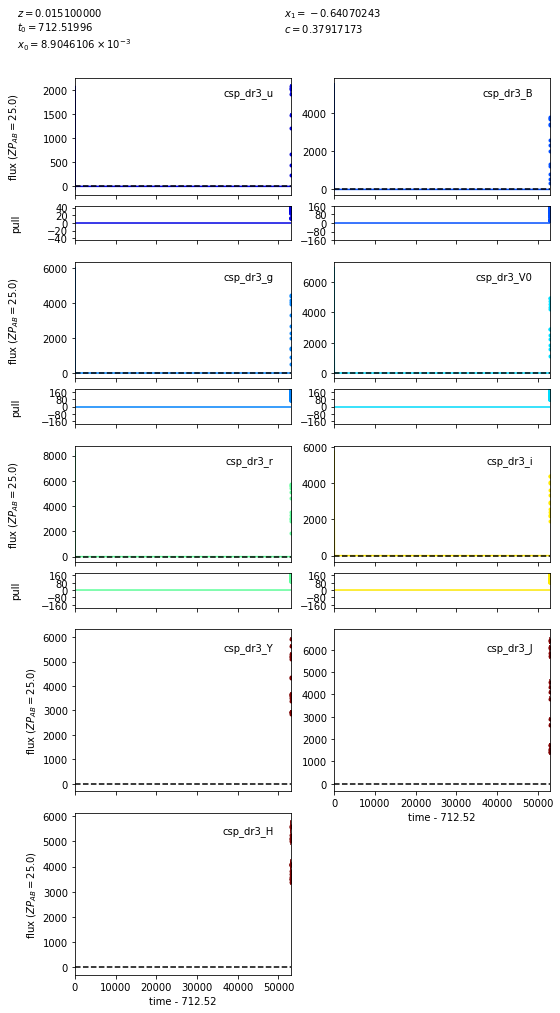

In [5]:
test_id = '2005kc'
salt2 = sncosmo.Model('salt2')
data = dr3.get_data_for_id(test_id, format_sncosmo=True)
priors = utils.get_priors(dr3, salt2).loc[test_id]

salt2.set(z=data.meta['redshift'])
bounds = dict()
for p in salt2.param_names:
    bounds[p] = (priors[f'{p}_min'], priors[f'{p}_max'])
    salt2.update({p: priors[p]})

fit_result, fit_model = sncosmo.fit_lc(data, salt2, ['t0', 'x0', 'x1', 'c'], bounds=bounds, phase_range=(-20,50))
sncosmo.plot_lc(data, fit_model)
plt.show()


We compare the chi-squared 

In [6]:
sncosmo_chisq = fit_result['chisq'] / fit_result['ndof']
print('Chi-Squared from fit_lc:', sncosmo_chisq)

pipeline_data = utils.get_fit_results(dr3, salt2, 4, 'all').loc[test_id]
print('Pipeline Chi-squared using all data:', 
      pipeline_data['chi'] / pipeline_data['dof'])


Chi-Squared from fit_lc: -0.0
Pipeline Chi-squared using all data: 52.660514329736266


Next we do the same but use the 91bg model. We expect this model to perfom much more poorly.

In [4]:
test_id = '2007S'
sn91bg = sncosmo.Model('sn91bg')
data = dr3.get_data_for_id(test_id, format_sncosmo=True)
priors = utils.get_priors(dr3, sn91bg).loc[test_id]

sn91bg.set(z=data.meta['redshift'])
bounds = dict()
for p in sn91bg.param_names:
    bounds[p] = (priors[f'{p}_min'], priors[f'{p}_max'])
    sn91bg.update({p: priors[p]})

fit_result, fit_model = sncosmo.fit_lc(data, sn91bg, ['t0', 'x0', 'x1', 'c'], bounds=bounds, phase_range=(-20,50))
sncosmo.plot_lc(data, fit_model)
plt.show()


KeyError: '2007S'

In [ ]:
sncosmo_chisq = fit_result['chisq'] / fit_result['ndof']
print('Chi-Squared from fit_lc:', sncosmo_chisq)

pipeline_data = utils.get_fit_results(dr3, sn91bg, 4, 'all').loc[test_id]
print('Pipeline Chi-squared using all data:', 
      pipeline_data['chi'] / pipeline_data['dof'])


Self-implemented lc-fitting plots for clarity.

In [ ]:
fig = plt.figure(figsize=(10, 12))
ax = [plt.subplot(3, 2, i + 1) for i in range(6)]

b = ['csp_dr3_u', 'csp_dr3_B', 'csp_dr3_g', 'csp_dr3_V', 'csp_dr3_r', 'csp_dr3_i']
plot_color = ['darkblue', 'blue', 'aqua', 'lightblue', 'lightgreen', 'yellow']
for i in range(6):
    data_this = data[data['band'] == b[i]]
    ax[i].errorbar(data_this['time'], data_this['flux'], yerr=data_this['fluxerr'], fmt='.', markersize=3, capsize=2)
    xtime = np.arange(data_this['time'].min(), data_this['time'].max(),0.1)
    yflux = [fit_model.bandflux(data_this['band'][0], t) for t in xtime]
    ax[i].plot(xtime, yflux, c=plot_color[i], label=b[i])
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Flux')
    ax[i].legend()


## Fitting Individual Bands

In addition to fitting all available bands at once, we also fit individual band passes and look at the chi-squared values summed over the individual bands.

In [ ]:
band_sncosmo_chisq = dict()
band_pipeline_chisq = dict()
for band in set(data['band']):
    band_data = data[data['band'] == band]
    vparams=['t0', 'x0', 'x1', 'c']
    try:
        snc_result, fitted_model = sncosmo.fit_lc(band_data, salt2, vparams, phase_range=(-15,50))
        
    except RuntimeError:
        continue
    
    
    # Calculate chi-squared
    pipe_chisq, num_points = calc_chisq(band_data, fitted_model)
    pipe_dof = len(band_data) - len(vparams)
    band_pipeline_chisq[band] = pipe_chisq / pipe_dof
    band_sncosmo_chisq[band] = snc_result['chisq'] / snc_result['ndof']

print('SNCosmo Chi-Squared:')
print(band_sncosmo_chisq)

print('\nSNCosmo Chi-Squared summed over bands:')
print(sum(i for i in band_sncosmo_chisq.values()))

print('\nPipeline Chi-Squared:')
print(band_pipeline_chisq)

print('\nPipeline Chi-Squared summed over bands:')
print(sum(i for i in band_pipeline_chisq.values()))
